# Stack Overflow

## Introduction 

In this project, I have measured the similarity of users by analyzing the types of questions they answer.

Below is a function to parse out the questions posted in 2015. These are posts with `PostTypeId=1`. I have made a `pandas DataFrame` with 4 columns: `Id`, `CreationDate`, `OwnerUserId`, and the first tag in `Tags`. I have parsed out the data to `question_dataframe.csv` first and then create the `pandas DataFrame` using `read_csv()`.


In [1]:
import pandas as pd
from pandas import Series, DataFrame
import xml.etree.ElementTree as ET
import csv

Posts_data = open('question_dataframe.csv','w')
csvwriter = csv.writer(Posts_data)
columns = ['Id','CreationDate','OwnerUserId','Tags']
csvwriter.writerow(columns)
iterparser = ET.iterparse('stackoverflow-posts-2015.xml', events=('start',))
iterator = iter(iterparser)
event, root = next(iterator)

for event, element in iterator:
    rows= []
    if element.tag == 'row':
        if element.get('PostTypeId','') == '1':
            Id= element.get('Id','')
            rows.append(Id)
            CreationDate= element.get('CreationDate','')
            rows.append(CreationDate)
            OwnerUserId= element.get('OwnerUserId','')
            rows.append(OwnerUserId)
            Tags= element.get('Tags','')
            start = Tags.find('<')
            end = Tags.find('>')
            Tags = Tags[start+1:end]
            rows.append(Tags)
            csvwriter.writerow(rows)
    root.clear()
Posts_data.close()
df = pd.read_csv('question_dataframe.csv')
x = len(df)
print('The Length of the DataFrame is: {}'.format(x))
print('Done')
        





The Length of the DataFrame is: 2530504
Done


The code above takes approximately 4-5 minutes to execute

We are now ready to tackle our original problem. Below is a function to measure the similarity of the top 100 users with the most answer posts. The users are compared based on the types of questions they answer. I have categorized a question by its first tag using euclidean distance. You may choose to implement any one of the similarity/distance measures.

Note that answers are posts with `PostTypeId=2`. The ID of the question in answer posts is the `ParentId`.

In [4]:
from collections import OrderedDict
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.feature_extraction.text
import pandas
import re
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
from nltk.stem import SnowballStemmer

def preprocessor(data):
    return " ".join([SnowballStemmer('english').stem(word) for word in data]) #pre-processes the data before fitting it

answers_data = open('answers_dataframe.csv','w')
csvwriter = csv.writer(answers_data)
col = ['Id_ans','Id','OwnerUserId_ans'] #column Id_ans stores the actual Id of posts with typeId = 2 and Column 'Id' stores ParentId (renaming done for performing Join) 
csvwriter.writerow(col)
iterparser = ET.iterparse('stackoverflow-posts-2015.xml', events=('start',))
iterator = iter(iterparser)
event, root = next(iterator)

for event, element in iterator:
    tuples= []
    if element.tag == 'row':
        if element.get('PostTypeId','') == '2':
            Id_ans= element.get('Id','')
            Id_ans = Id_ans + " "
            tuples.append(Id_ans)
            ParentId= element.get('ParentId','')
            ParentId = ParentId + " "
            tuples.append(ParentId)
            OwnerUserId_ans = element.get('OwnerUserId','')
            OwnerUserId_ans = OwnerUserId_ans + " "
            tuples.append(OwnerUserId_ans)
            csvwriter.writerow(tuples)
    root.clear()
answers_data.close()

df1 = pd.read_csv('answers_dataframe.csv')
join_df = pd.merge(df,df1,on='Id', )
join_df['freq'] = join_df.groupby('OwnerUserId_ans')['OwnerUserId_ans'].transform('count')
join_df = join_df.sort('freq', ascending = False)
piv1 = join_df[['OwnerUserId_ans','Tags']]
piv1 = piv1.reset_index(drop = True)
x = {k: g['Tags'].tolist() for k,g in piv1.groupby('OwnerUserId_ans')}
od = OrderedDict(sorted(x.items(), key=lambda kv:len(kv[1]), reverse=True))

top100 = dict((list(od.items())[:100])[::-1])
t100 = top100.values()

vec = CountVectorizer(preprocessor=preprocessor).fit(t100)
final = vec.transform(t100)
vector = final.toarray()
print(type(vector), vector.shape)
euclidean_dists = metrics.euclidean_distances(vector)
print('Similarity between the top 100 users:')
print(euclidean_dists)

#The code above takes 5 minutes to execute

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:43: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


<class 'numpy.ndarray'> (100, 1063)
Similarity between the top 100 users:
[[    0.          2953.08465845  2814.54294691 ...,  3037.83475522
   1923.41259224  3081.67778978]
 [ 2953.08465845     0.           958.82167268 ...,  1486.42423285
   1274.34179089   363.01928323]
 [ 2814.54294691   958.82167268     0.         ...,  1210.25369241
    927.00053937  1304.24844259]
 ..., 
 [ 3037.83475522  1486.42423285  1210.25369241 ...,     0.          1467.32682113
   1730.47796865]
 [ 1923.41259224  1274.34179089   927.00053937 ...,  1467.32682113     0.
   1553.41237281]
 [ 3081.67778978   363.01928323  1304.24844259 ...,  1730.47796865
   1553.41237281     0.        ]]


The figure below is a plot of distance of the top 100 users using a [heatmap](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.heatmap.html).

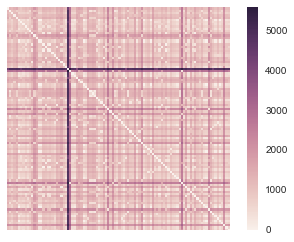

In [91]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

_ = sns.heatmap(euclidean_dists, xticklabels=False, yticklabels=False, linewidths=0, 
            square=True,cbar="YlGnBu")


-----------------